# Parameter Estimation: Example 2

Continuing from the example in {doc}`.estimate1`, we show why estimating the parameters
for ODE's can be difficult. This is especially true if there is a lack of data
or when there are too much flexibility in the model. 

```{note}
For reproducibility purposes, only deterministic models are used here. If a stochastic algorithm is required we use a fixed seed.
```


## SEIR model

We demonstrate the estimation on data collected from an Ebola outbreak in West
Africa. We use the number of deaths in Guinea and its corresponding time
the data was recorded. These data are publicly available and they can be
obtained [here](https://github.com/cmrivers/ebola). 

We provide the data here for reproducibility and ease.

In [2]:
# the number of deaths and cases in Guinea

yDeath = [29.0, 59.0, 60.0, 62.0, 66.0, 70.0, 70.0, 80.0, 83.0, 86.0, 95.0, 101.0, 106.0, 108.0, 122.0, 129.0, 136.0, 141.0, 143.0, 149.0, 155.0, 157.0, 158.0,
157.0, 171.0, 174.0, 186.0, 193.0, 208.0, 215.0, 226.0, 264.0,
267.0, 270.0, 303.0, 305.0, 307.0, 309.0, 304.0, 310.0, 310.0,
314.0, 319.0, 339.0, 346.0, 358.0, 363.0, 367.0, 373.0, 377.0,
380.0, 394.0, 396.0, 406.0, 430.0, 494.0, 517.0, 557.0, 568.0, 595.0,
601.0, 632.0, 635.0, 648.0, 710.0, 739.0, 768.0, 778.0, 843.0,
862.0, 904.0, 926.0, 997.0]

yCase = [49.0, 86.0, 86.0, 86.0, 103.0, 112.0, 112.0, 122.0, 127.0, 143.0, 151.0, 158.0, 159.0, 168.0, 197.0, 203.0, 208.0, 218.0, 224.0, 226.0, 231.0,
235.0, 236.0, 233.0, 248.0, 258.0, 281.0, 291.0, 328.0, 344.0,
351.0, 398.0, 390.0, 390.0, 413.0, 412.0, 408.0, 409.0, 406.0,
411.0, 410.0, 415.0, 427.0, 460.0, 472.0, 485.0, 495.0, 495.0,
506.0, 510.0, 519.0, 543.0, 579.0, 607.0, 648.0, 771.0, 812.0,
861.0, 899.0, 936.0, 942.0, 1008.0, 1022.0, 1074.0, 1157.0, 1199.0,
1298.0, 1350.0, 1472.0, 1519.0, 1540.0, 1553.0, 1906.0]

In [3]:
# the corresponding time

t = [0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 9.0, 10.0, 13.0, 16.0, 18.0, 20.0, 23.0, 25.0, 26.0, 29.0, 32.0, 35.0, 40.0, 42.0, 44.0, 46.0, 49.0, 51.0, 62.0, 66.0, 67.0,
71.0, 73.0, 80.0, 86.0, 88.0, 90.0, 100.0, 102.0, 106.0, 108.0,
112.0, 114.0, 117.0, 120.0, 123.0, 126.0, 129.0, 132.0, 135.0, 137.0, 140.0, 142.0, 144.0, 147.0, 149.0, 151.0, 157.0, 162.0, 167.0,
169.0, 172.0, 175.0, 176.0, 181.0, 183.0, 185.0, 190.0, 193.0,
197.0, 199.0, 204.0, 206.0, 211.0, 213.0, 218.0]

### Simple estimation

First, we are going to fit a standard **SEIR** model to the data.
Details of the models can be found in {doc}`common_models` Defining the model
as usual with an approximation of what the parameters might be, here,
we choose the values to be the mid point of our feasible region (defined
by our box constraints later).

Let's see what the data looks like:

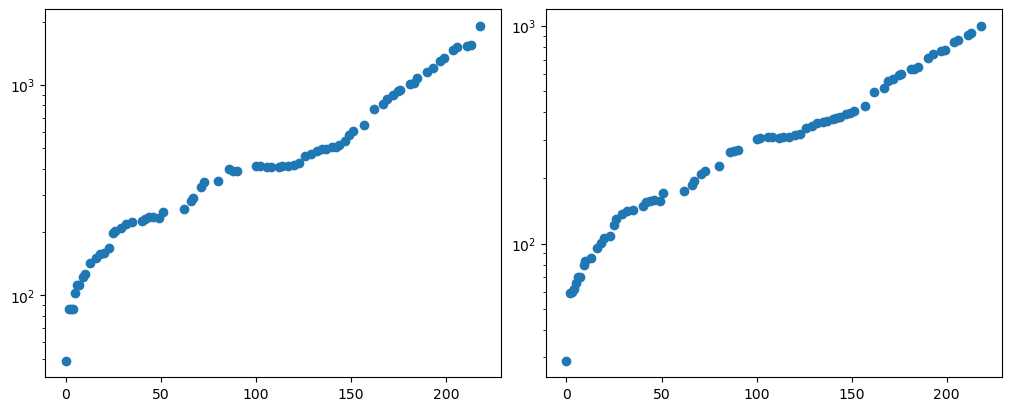

In [27]:
import numpy
population = 1175e4
y = numpy.reshape(numpy.append(numpy.array(yCase), numpy.array(yDeath)),
                  (len(yCase),2), 'F')#/population

import matplotlib.pyplot as plt

f, axarr = plt.subplots(1,2, layout='constrained', figsize=(10, 4))

axarr[0].scatter(t, y[:,0])
axarr[1].scatter(t, y[:,1])
axarr[0].set_yscale('log')
axarr[1].set_yscale('log')

Let's set up model

In [10]:
# Define SIR model
from pygom import SimulateOde, Transition, TransitionType
stateList = ['S', 'E', 'I', 'R']
paramList = ['beta', 'alpha', 'gamma']

transitionList = [Transition(origin='S', destination='E', equation='beta*S*I', transition_type=TransitionType.T),
                  Transition(origin='E', destination='I', equation='alpha*E', transition_type=TransitionType.T),
                  Transition(origin='I', destination='R', equation='gamma*I', transition_type=TransitionType.T)]

ode_obj = SimulateOde(stateList, paramList, transition=transitionList)

theta = numpy.array([5.0, 5.0, 5.0])
ode_obj.parameters=theta

from pygom import SquareLoss

x0 = [1., 0., 49.0/population, 29.0/population]

objLegrand = SquareLoss(theta, ode_obj,
                        t0=t[0], x0=x0,
                        t=t[1::], y=y[1::,:],
                        state_name=['I','R'],
                        state_weight=numpy.sqrt(population*2)) 

Now let's param


Then we optimize, first, assuming that the initial conditions are
accurate. Some relatively large bounds are used for this particular
problem.


In [11]:
import scipy.optimize

boxBounds = [ (0.0,10.0), (0.0,10.0), (0.0,10.0)]

res = scipy.optimize.minimize(fun=objLegrand.cost, jac=objLegrand.sensitivity, x0=theta, bounds=boxBounds, method='l-bfgs-b')

print(res)


  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 9.045332633285773e-07
        x: [ 4.919e+00  5.000e+00  5.079e+00]
      nit: 10
      jac: [ 9.551e-06  1.237e-08 -9.238e-06]
     nfev: 11
     njev: 11
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


<Figure size 640x480 with 0 Axes>

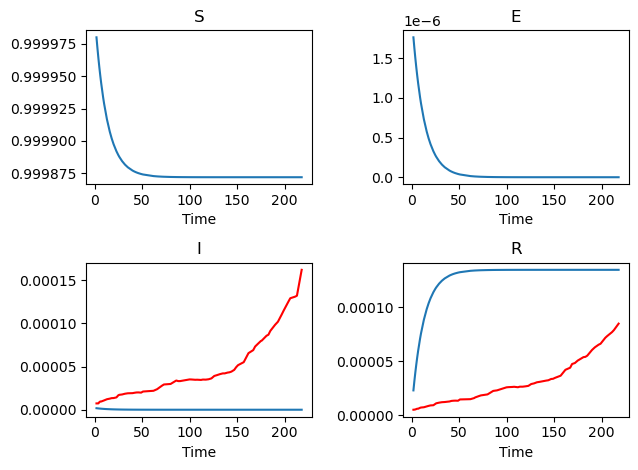

In [12]:
f = plt.figure()

objLegrand.plot()

plt.close()



We can see from our visual confirmation that the estimated parameters
are not exactly ideal. This is confirmed by the information returned
from the `scipy.optimize.minimize` routine, and probably caused by the
poor starting point. An attempt to find a more suitable value can be
done by some form of parameter space exploration. Given that the
evaluation of the objective function is not expensive here, we have
plenty of options to choose from. To reduce the number of packages
required to build this documentation, routines from `scipy.optimize`
remain our preferred option.


### Improved initial guess

In [13]:
resDE = scipy.optimize.differential_evolution(objLegrand.cost,
bounds=boxBounds, polish=False, seed=20921391)

print(objLegrand.sensitivity(resDE['x']))


[ 3.11038452e-09  7.85178078e-06 -3.60499243e-08]


<Figure size 640x480 with 0 Axes>

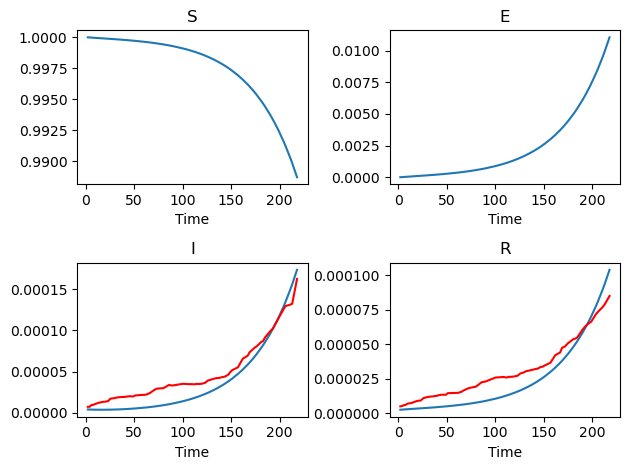

In [14]:
f = plt.figure()

objLegrand.plot()

plt.close()


Looking at the output of the estimates (below this paragraph), we can
see our inference on Ebola is wrong when compared to the *known* values
(from field observations) even though the graphs looks *\`\`reasonable"*.
Namely, $\gamma^{-1}$, the third parameter in the vector below, our time
from infectiousness to death, is within the expected range but $\alpha^{-1}$
(second parameter), the incubation period, is a lot higher than expected.


In [15]:
1/resDE['x']

array([7.13160861e-01, 1.88609866e+03, 8.00526800e+01])


### Multimodal surface

A reason for this type of behavior is that we simply lack the
information/data to make proper inference. Without data on the state
$E$, the parameters $\beta,\alpha$ for the two states $I$ and $E$ are
dependent only on observations on $I$. Hence, some other random
combination of $\beta,\alpha$ that is capable of generating realizations
close to observations in $I$ is feasible. In such cases, the only
requirement is that there exist some $\gamma$ in the feasible region
that can compensate for the ill suited $\beta,\alpha$. For example, we
know (obtained elsewhere and not shown here) that there is another set
of parameters capable of generating a similar looking curves as before.
Note the reversal of magnitude in $\beta$ and $\alpha$.



In [16]:
objLegrand.cost([3.26106524e+00, 2.24798702e-04, 1.23660721e-02])

# objLegrand.cost([ 0.02701867, 9.00004776, 0.01031861])
# similar graph


1.90984074647533e-08

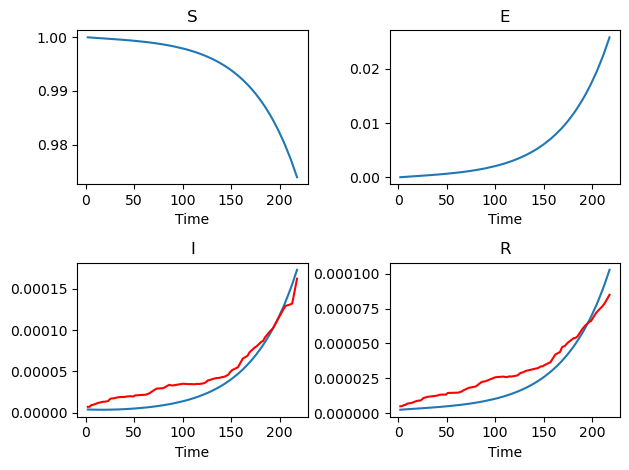

In [17]:
objLegrand.plot()

### With initial values as parameters

The assumption that the whole population being susceptible is
an overestimate, therefore we want to estimate the initial conditions of the
ODEs as well. Given previous estimates of the parameters
$\hat{\beta}, \hat{\alpha}, \hat{\gamma}$ it is appropriate to start our
initial guess there.

Furthermore, given that we now estimate the initial values for all the
states, we can use the first time point as our observation. So our time
begins at $t = -1$ where our observations include the previous initial
condition, i.e. 49 and 29 for the number of cases and death at $t = 0$
respectively. The following code block demonstrates how we would do
that; feel free to try it out yourself to see the much improved result.



In [19]:
thetaIV = theta.tolist() + x0

thetaIV[3] -= 1e-8 # to make sure that the initial guess satisfies the constraints

thetaIV


[5.0, 5.0, 5.0, 0.99999999, 0.0, 4.170212765957447e-06, 2.468085106382979e-06]

In [20]:
objLegrand = SquareLoss(theta, ode_obj,
                        t0=t[0], x0=x0,
                        t=t[1::], y=y[1::,:],
                        state_name=['I','R'],
                        state_weight=numpy.sqrt(population*2)) 

boxBoundsIV = boxBounds + [(0.,1.), (0.,1.), (0.,1.), (0.,1.)]

resDEIV = scipy.optimize.differential_evolution(objLegrand.costIV, bounds=boxBoundsIV, polish=False, seed=20921391)

print(resDEIV)

             message: Optimization terminated successfully.
             success: True
                 fun: 6.267485095752834
                   x: [ 3.850e+00  2.211e-02  4.114e+00  6.482e-01
                        2.643e-06  4.215e-06  1.967e-05]
                 nit: 99
                nfev: 10500
          population: [[ 3.850e+00  2.211e-02 ...  4.215e-06  1.967e-05]
                       [ 4.083e+00  6.271e+00 ...  8.164e-06  1.845e-05]
                       ...
                       [ 4.550e+00  7.734e+00 ...  5.920e-06  1.729e-05]
                       [ 4.326e+00  3.862e-03 ...  8.806e-06  1.406e-05]]
 population_energies: [ 6.267e+00  6.619e+00 ...  6.721e+00  6.385e+00]


objLegrand.plot()


## Legrand Ebola SEIHFR Model

Next, we demonstrate the estimation on a model that has been widely used in
the 2014 Ebola outbreak in west Africa {citets}`Legrand`. This model has been
defined in {mod}`.common_models`.



In [21]:
from pygom import common_models
ode = common_models.Legrand_Ebola_SEIHFR()

# initial guess from the paper that studied the outbreak in Congo

theta = numpy.array([0.588,0.794,7.653, # the beta  
                    10.0,9.6,5.0,2.0, # the omega
                    7.0,0.81,0.80, # alpha,
                    delta, 
                    theta,
                    100.,1.0]) # kappa,intervention time

# initial conditions, note that we have a 0.0 at the end because the model is a non-automonous ODE which we have converted the time component out of

x0 = numpy.array([population, 0.0, 49.0, 0.0, 0.0, 29.0, 0.0])/population

ode.parameters = theta

ode.initial_values = (x0, t[0])

objLegrand = SquareLoss(theta, ode, x0, t[0], t[1::], y[1::,:], 
                        ['I','R'], numpy.sqrt([population]*2))

NameError: name 'delta' is not defined

Now, it is important to set additional constraints accurately because a
simple box constraint is much larger than the feasible set. Namely,
$\omega_{I}, \omega_{D}$ are the time taken from onset until end of
infectious/death, which has to be bigger than $\omega_{H}$, onset to
hospitalization given the nature of the disease. Therefore, we create
extra inequality constraints in addition to the box constraints

In [ ]:
boxBounds = [(0.001, 100.), #beta_I 
             (0.001, 100.), # beta_H
             (0.001, 100.), # beta_F 
             (0.001, 100.), # omega_I 
             (0.001, 100.), # omega_D 
             (0.001, 100.), # omega_H 
             (0.001, 100.), # omega_F
             (0.001, 100.), # alpha^{-1} 
             (0.0001, 1.), # delta 
             (0.0001, 1.), # theta .….: (0.001, 1000.), # kappa
             (0.,218.) # intervention time 
             ]

cons = ({'type': 'ineq', 'fun' : lambda x: numpy.array([x[3]-x[5], x[4]-x[5]])})

We can now try to find the optimal values, but because this is a
difficult problem that can take a very long time without guarantee on
the quality of solution.

res = scipy.optimize.minimize(fun=objLegrand.cost, jac=objLegrand.sensitivity, 
                              x0=theta, constraints=cons, bounds=boxBounds, method='SLSQP')

print(res)



objLegrand.plot()

The estimated parameters are very much unrealistic given that
a lot of them are near the boundaries. It is also known from other
sources that some of the epidemiology properties of Ebola, with
incubation period of around 2 weeks and a mortality rate of around 80
percent.

As the estimate does not appear to provide anything sensible, we also
provide a set of values previously obtained (that looks semi-reasonable)
here plot the epidemic curve with the observations layered on top.



theta = numpy.array([3.96915071e-02, 1.72302620e+01, 1.99749990e+01, 2.67759445e+01, 
                     4.99999990e+01, 5.56122691e+00, 4.99999990e+01, 8.51599523e+00, 
                     9.99999000e-01, 1.00000000e-06, 3.85807562e+00, 1.88385318e+00])

print(objLegrand.cost(theta))

In [ ]:
solution = ode.integrate(t[1::])

f, axarr = plt.subplots(2,3)

axarr[0,0].plot(t, solution[:,0]);

axarr[0,0].set_title('Susceptible');

axarr[0,1].plot(t, solution[:,1]);

axarr[0,1].set_title('Exposed');

axarr[0,2].plot(t, solution[:,2]);

 axarr[0,2].plot(t, y[:,0], 'r');

axarr[0,2].set_title('Infectious');

axarr[1,0].plot(t, solution[:,3]);

axarr[1,0].set_title('Hospitalised');

axarr[1,1].plot(t, solution[:,4]);

axarr[1,1].set_title('Awaiting Burial');

axarr[1,2].plot(t, solution[:,5]);

axarr[1,2].plot(t, y[:,1], 'r');

axarr[1,2].set_title('Removed');

f.text(0.5, 0.04, 'Days from outbreak', ha='center');

f.text(0.01, 0.5, 'Population', va='center', rotation='vertical');

f.tight_layout();

plt.show()